In [5]:
import torch
import torch.nn as nn
import torch_geometric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
import json
import os

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Carlos\anaconda3\envs\pytorch\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


 Similarity metrics

In [6]:
# PyTorch implementations of Polynomial Kernels

def polynomial_kernel(X, Y, degree=2, gamma=1.0, coef0=1.0):
    """
    Polynomial kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param degree: int, default=2
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = (gamma * torch.mm(X, Y.t()) + coef0) ** degree
    return K

def rbf_kernel(X, Y, gamma=None):

    """
    Rbf kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||^2)
    d_XY = torch.cdist(X, Y, p=2) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY ** 2)

    return K

def laplacian_kernel(X, Y, gamma=None):
    """
    Laplacian kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||)
    d_XY = torch.cdist(X, Y, p=1) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY)

    return K

def sigmoid_kernel(X, Y, gamma=1.0, coef0=1.0):
    """
    Sigmoid kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = torch.tanh(gamma * torch.mm(X, Y.t()) + coef0)
    return K


In [7]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return polynomial_kernel(X = X, Y = X, degree = degree, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "sigmoid":
 
        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return sigmoid_kernel(X = X, Y = X, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return rbf_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return laplacian_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    else:
        return None


In [8]:
def compute_centroids(X, y):
    label_matrix = binary_distance(y.unique().unsqueeze(1), y.unsqueeze(1))
    label_matrix = torch.div(label_matrix, torch.sum(label_matrix, dim=1).unsqueeze(1))
    return torch.matmul(label_matrix, X), y.unique()

Model definition

In [131]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, latent_size)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        return x

class Encoder_SLMVP(nn.Module):
    def __init__(self, encoder, kernel_parameters_X, optimizer, label_indep = False, kernel_parameters_Y = None, lam = 0.3):
        super().__init__()
        self.encoder = encoder
        self.kernel_parameters_X = kernel_parameters_X
        self.optimizer = optimizer
        self.label_indep = label_indep
        self.kernel_parameters_Y = kernel_parameters_Y
        self.lam = lam
        self.criterion = nn.MSELoss()
    
    def encode(self, x):
        return self.encoder(x)
    
    def train_model(self, data_loader):
        self.train()
        
        epoch_losses = []

        for X, y in tqdm(data_loader):
            self.optimizer.zero_grad()
            Z = self.encode(X)

            # Calculation of similarity matrices
            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X
                K_Y = kernel(y, **self.kernel_parameters_Y)
            K_XY = K_X * K_Y
            distance_matrix = torch.cdist(Z, Z, p=2)
            K_Z = kernel(Z, **self.kernel_parameters_X)
            loss = torch.sum(K_XY * distance_matrix)
            epoch_losses.append(loss)

            loss.backward()
            self.optimizer.step()
        
        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        return avg_loss.item()
    
    def test_model(self, data_loader):
        self.eval()
        epoch_losses = []

        with torch.no_grad():
            for X, y in data_loader:
                Z = self.encode(X)

                # Calculation of similarity matrices
                K_X = kernel(X, **self.kernel_parameters_X)
                if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
                else:
                    if self.kernel_parameters_Y == None:
                        self.kernel_parameters_Y = self.kernel_parameters_X
                    K_Y = kernel(y, **self.kernel_parameters_Y)
                K_XY = K_X * K_Y
                distance_matrix = torch.cdist(Z, Z, p=2)
                loss = torch.sum(K_XY * distance_matrix)
                epoch_losses.append(loss)
            
        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        return avg_loss.item()
            
            

    


Model hyperparameters

In [162]:
lr = 0.0001 # learning rate
batch_size = 256
epochs = 1000
latent_size = 64 # latent space dimension

kernel_param_X = {

    
    "kernel_type": "rbf", # K(x, y) = exp(-gamma ||x-y||^2)
    "degree": 2,
    "gamma": 5,
    "coef": 0

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

MNIST Fashion preprocessing

In [ ]:
# !git clone "https://github.com/Carlosespicur/tfm_esteban"

In [16]:


# train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

train_data = pd.read_csv("fashion_MNIST/fashion-mnist_train.csv")
test_data = pd.read_csv("fashion_MNIST/fashion-mnist_test.csv")
data = pd.concat([train_data, test_data], ignore_index = True)
# print(train_data.shape, test_data.shape, data.shape)
# data.head()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# print(train_data["label"].value_counts(normalize=True))
# print(val_data["label"].value_counts(normalize=True))
# print(test_data["label"].value_counts(normalize=True))

X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = train_data["label"].values
y_train = torch.tensor(y_train, dtype = torch.float)
X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = val_data["label"].values
y_val = torch.tensor(y_val, dtype = torch.float)
X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
X_test = torch.tensor(X_test, dtype = torch.float)
y_test = test_data["label"].values
y_test = torch.tensor(y_test, dtype = torch.float)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

input_size = X_train.size(1)

In [ ]:
# # PRUEBA CON DATASET ORIGINAL 

# # train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# # test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

# train_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_test.csv")
# # data = pd.concat([train_data, test_data], ignore_index = True)
# # print(train_data.shape, test_data.shape, data.shape)
# # data.head()
# # train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
# train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# # print(train_data["label"].value_counts(normalize=True))
# # print(val_data["label"].value_counts(normalize=True))
# # print(test_data["label"].value_counts(normalize=True))

# X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
# X_train = torch.tensor(X_train, dtype = torch.float)
# y_train = train_data["label"].values
# y_train = torch.tensor(y_train, dtype = torch.float)
# X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
# X_val = torch.tensor(X_val, dtype = torch.float)
# y_val = val_data["label"].values
# y_val = torch.tensor(y_val, dtype = torch.float)
# X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
# X_test = torch.tensor(X_test, dtype = torch.float)
# y_test = test_data["label"].values
# y_test = torch.tensor(y_test, dtype = torch.float)

# train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
# val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
# test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

# input_size = X_train.size(1)

Model creation

In [163]:
encoder = Encoder(input_size, latent_size)
optimizer = Adam(list(encoder.parameters()), lr = lr)

model = Encoder_SLMVP(encoder, kernel_param_X, optimizer, label_indep, kernel_param_Y, lam=0)



Model training

In [164]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    avg_loss_train = model.train_model(train_loader)
    avg_loss_val = model.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train}")
    print(f"avg_loss_val: {avg_loss_val}")


Epoch: 1/1000


100%|██████████| 394/394 [00:03<00:00, 114.05it/s]


avg_loss_train: 0.007362591568380594
avg_loss_val: 0.0071528698317706585
Epoch: 2/1000


100%|██████████| 394/394 [00:03<00:00, 116.08it/s]


avg_loss_train: 0.007278915029019117
avg_loss_val: 0.006936999969184399
Epoch: 3/1000


100%|██████████| 394/394 [00:03<00:00, 122.16it/s]


avg_loss_train: 0.007443688809871674
avg_loss_val: 0.009309404529631138
Epoch: 4/1000


100%|██████████| 394/394 [00:03<00:00, 122.40it/s]


avg_loss_train: 0.012369728647172451
avg_loss_val: 0.0233518797904253
Epoch: 5/1000


100%|██████████| 394/394 [00:03<00:00, 122.02it/s]


avg_loss_train: 0.02342396415770054
avg_loss_val: 0.022662028670310974
Epoch: 6/1000


100%|██████████| 394/394 [00:03<00:00, 123.68it/s]


avg_loss_train: 0.014609725214540958
avg_loss_val: 0.012296787463128567
Epoch: 7/1000


100%|██████████| 394/394 [00:03<00:00, 124.65it/s]


avg_loss_train: 0.012492435052990913
avg_loss_val: 0.012304708361625671
Epoch: 8/1000


100%|██████████| 394/394 [00:03<00:00, 118.86it/s]


avg_loss_train: 0.012538665905594826
avg_loss_val: 0.01279563270509243
Epoch: 9/1000


100%|██████████| 394/394 [00:03<00:00, 117.36it/s]


avg_loss_train: 0.011608187109231949
avg_loss_val: 0.011819279752671719
Epoch: 10/1000


100%|██████████| 394/394 [00:03<00:00, 123.83it/s]


avg_loss_train: 0.014988471753895283
avg_loss_val: 0.02379775233566761
Epoch: 11/1000


100%|██████████| 394/394 [00:03<00:00, 126.28it/s]


avg_loss_train: 0.023461734876036644
avg_loss_val: 0.023038582876324654
Epoch: 12/1000


100%|██████████| 394/394 [00:03<00:00, 123.59it/s]


avg_loss_train: 0.02371065318584442
avg_loss_val: 0.024137945845723152
Epoch: 13/1000


100%|██████████| 394/394 [00:03<00:00, 120.16it/s]


avg_loss_train: 0.022974951192736626
avg_loss_val: 0.022933177649974823
Epoch: 14/1000


100%|██████████| 394/394 [00:03<00:00, 121.99it/s]


avg_loss_train: 0.022967984899878502
avg_loss_val: 0.023723935708403587
Epoch: 15/1000


100%|██████████| 394/394 [00:03<00:00, 121.62it/s]


avg_loss_train: 0.02275693416595459
avg_loss_val: 0.02143932692706585
Epoch: 16/1000


100%|██████████| 394/394 [00:03<00:00, 125.28it/s]


avg_loss_train: 0.02218266949057579
avg_loss_val: 0.02240309864282608
Epoch: 17/1000


100%|██████████| 394/394 [00:03<00:00, 123.77it/s]


avg_loss_train: 0.04208945110440254
avg_loss_val: 0.023458540439605713
Epoch: 18/1000


100%|██████████| 394/394 [00:03<00:00, 116.81it/s]


avg_loss_train: 0.02279611863195896
avg_loss_val: 0.020876361057162285
Epoch: 19/1000


100%|██████████| 394/394 [00:03<00:00, 121.69it/s]


avg_loss_train: 0.020247386768460274
avg_loss_val: 0.021239113062620163
Epoch: 20/1000


100%|██████████| 394/394 [00:03<00:00, 122.60it/s]


avg_loss_train: 0.019874632358551025
avg_loss_val: 0.02010410465300083
Epoch: 21/1000


100%|██████████| 394/394 [00:03<00:00, 117.12it/s]


avg_loss_train: 0.020285483449697495
avg_loss_val: 0.02238796092569828
Epoch: 22/1000


100%|██████████| 394/394 [00:03<00:00, 121.12it/s]


avg_loss_train: 0.02369837276637554
avg_loss_val: 0.023192472755908966
Epoch: 23/1000


100%|██████████| 394/394 [00:03<00:00, 126.89it/s]


avg_loss_train: 0.02537049911916256
avg_loss_val: 0.03187717869877815
Epoch: 24/1000


100%|██████████| 394/394 [00:03<00:00, 128.18it/s]


avg_loss_train: 0.029570546001195908
avg_loss_val: 0.024591557681560516
Epoch: 25/1000


100%|██████████| 394/394 [00:03<00:00, 114.63it/s]


avg_loss_train: 0.022246645763516426
avg_loss_val: 0.020192299038171768
Epoch: 26/1000


100%|██████████| 394/394 [00:03<00:00, 122.60it/s]


avg_loss_train: 0.019123757258057594
avg_loss_val: 0.007750475313514471
Epoch: 27/1000


100%|██████████| 394/394 [00:03<00:00, 112.51it/s]


avg_loss_train: 0.007994729094207287
avg_loss_val: 0.0075139012187719345
Epoch: 28/1000


100%|██████████| 394/394 [00:03<00:00, 108.37it/s]


avg_loss_train: 0.007530510891228914
avg_loss_val: 0.007342732977122068
Epoch: 29/1000


100%|██████████| 394/394 [00:03<00:00, 112.84it/s]


avg_loss_train: 0.007686999626457691
avg_loss_val: 0.006793553940951824
Epoch: 30/1000


100%|██████████| 394/394 [00:03<00:00, 114.91it/s]


avg_loss_train: 0.006751541513949633
avg_loss_val: 0.006808262784034014
Epoch: 31/1000


100%|██████████| 394/394 [00:03<00:00, 111.05it/s]


avg_loss_train: 0.0071373917162418365
avg_loss_val: 0.007497112732380629
Epoch: 32/1000


100%|██████████| 394/394 [00:03<00:00, 118.81it/s]


avg_loss_train: 0.006828470155596733
avg_loss_val: 0.006699697580188513
Epoch: 33/1000


100%|██████████| 394/394 [00:03<00:00, 122.89it/s]


avg_loss_train: 0.0067118932493031025
avg_loss_val: 0.006628291681408882
Epoch: 34/1000


100%|██████████| 394/394 [00:03<00:00, 119.47it/s]


avg_loss_train: 0.006914258468896151
avg_loss_val: 0.007464567199349403
Epoch: 35/1000


100%|██████████| 394/394 [00:03<00:00, 121.38it/s]


avg_loss_train: 0.007365145720541477
avg_loss_val: 0.007499274332076311
Epoch: 36/1000


100%|██████████| 394/394 [00:03<00:00, 117.86it/s]


avg_loss_train: 0.007430517114698887
avg_loss_val: 0.007620992138981819
Epoch: 37/1000


100%|██████████| 394/394 [00:03<00:00, 115.02it/s]


avg_loss_train: 0.00744234025478363
avg_loss_val: 0.007842945866286755
Epoch: 38/1000


100%|██████████| 394/394 [00:03<00:00, 117.46it/s]


avg_loss_train: 0.007818357087671757
avg_loss_val: 0.00775119848549366
Epoch: 39/1000


100%|██████████| 394/394 [00:03<00:00, 122.89it/s]


avg_loss_train: 0.007808282971382141
avg_loss_val: 0.007592696230858564
Epoch: 40/1000


100%|██████████| 394/394 [00:03<00:00, 128.85it/s]


avg_loss_train: 0.008418167009949684
avg_loss_val: 0.008649208582937717
Epoch: 41/1000


100%|██████████| 394/394 [00:03<00:00, 123.80it/s]


avg_loss_train: 0.008680859580636024
avg_loss_val: 0.008772865869104862
Epoch: 42/1000


100%|██████████| 394/394 [00:03<00:00, 119.37it/s]


avg_loss_train: 0.008600997738540173
avg_loss_val: 0.006920345593243837
Epoch: 43/1000


100%|██████████| 394/394 [00:03<00:00, 122.79it/s]


avg_loss_train: 0.006927171256393194
avg_loss_val: 0.0071271862834692
Epoch: 44/1000


100%|██████████| 394/394 [00:03<00:00, 116.08it/s]


avg_loss_train: 0.007883762009441853
avg_loss_val: 0.008032740093767643
Epoch: 45/1000


100%|██████████| 394/394 [00:03<00:00, 123.09it/s]


avg_loss_train: 0.008092164061963558
avg_loss_val: 0.008071314543485641
Epoch: 46/1000


100%|██████████| 394/394 [00:03<00:00, 127.40it/s]


avg_loss_train: 0.00792505219578743
avg_loss_val: 0.008016667328774929
Epoch: 47/1000


100%|██████████| 394/394 [00:03<00:00, 123.29it/s]


avg_loss_train: 0.008493339642882347
avg_loss_val: 0.007440097164362669
Epoch: 48/1000


100%|██████████| 394/394 [00:03<00:00, 119.91it/s]


avg_loss_train: 0.007693917490541935
avg_loss_val: 0.008692655712366104
Epoch: 49/1000


100%|██████████| 394/394 [00:03<00:00, 116.50it/s]


avg_loss_train: 0.008647020906209946
avg_loss_val: 0.00922955572605133
Epoch: 50/1000


100%|██████████| 394/394 [00:03<00:00, 116.82it/s]


avg_loss_train: 0.009421228431165218
avg_loss_val: 0.009445994161069393
Epoch: 51/1000


100%|██████████| 394/394 [00:03<00:00, 122.06it/s]


avg_loss_train: 0.009680265560746193
avg_loss_val: 0.009472686797380447
Epoch: 52/1000


100%|██████████| 394/394 [00:03<00:00, 117.12it/s]


avg_loss_train: 0.009506775066256523
avg_loss_val: 0.009351926855742931
Epoch: 53/1000


 67%|██████▋   | 265/394 [00:02<00:01, 111.94it/s]


KeyboardInterrupt: 

Model testing

In [138]:
model.test_model(test_loader)

0.016619961708784103

In [139]:
for X, y in test_loader:
    Z = model.encode(X)
    break

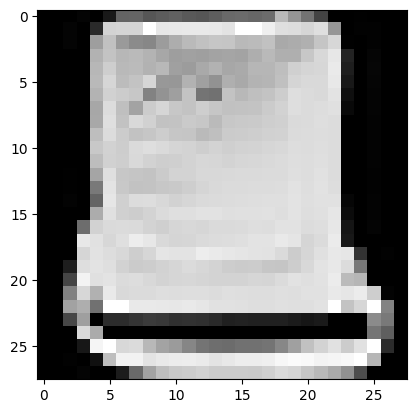

In [144]:
data_number = 18
prueba = X[data_number].detach().numpy().reshape(28, 28)
plt.imshow(prueba, cmap = "gray")

In [145]:
print(y[data_number])

print(Z[data_number])

tensor(8.)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.1719, 0.7333, 0.0000, 0.0000, 0.1543,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1100, 0.3996, 0.0000, 0.1956, 0.0000,
        0.0000, 0.1339, 0.1738, 0.0000, 0.0000, 0.4148, 0.0000, 0.0000, 0.0000,
        0.0572, 0.0000, 0.0000, 0.2917, 0.0000, 0.1572, 0.1463, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1638, 0.0000, 0.0000, 0.0000, 0.0000, 0.2053, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2076, 0.0000, 0.0000, 0.0000, 0.0000, 0.0911,
        0.0882, 0.0000, 0.0000, 0.0000, 0.0000, 0.1285, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)


In [146]:
K_Z = kernel(Z, **kernel_param_X)
K_X = kernel(X, **kernel_param_X)
K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

print(K_Z)
print(K_X)

tensor([[1.0000, 0.0511, 0.5334,  ..., 0.0262, 0.0056, 0.8287],
        [0.0511, 1.0000, 0.3531,  ..., 0.9422, 0.0016, 0.0522],
        [0.5334, 0.3531, 1.0000,  ..., 0.2335, 0.0029, 0.6050],
        ...,
        [0.0262, 0.9422, 0.2335,  ..., 1.0000, 0.0010, 0.0275],
        [0.0056, 0.0016, 0.0029,  ..., 0.0010, 1.0000, 0.0017],
        [0.8287, 0.0522, 0.6050,  ..., 0.0275, 0.0017, 1.0000]],
       grad_fn=<ExpBackward0>)
tensor([[0.9998, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9991]])


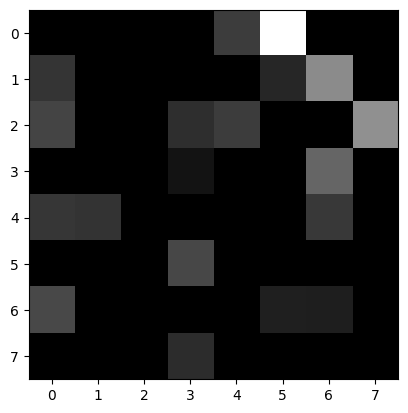

In [147]:
prueba_out = Z[data_number].detach().numpy().reshape(8, 8)
plt.imshow(prueba_out, cmap = "gray")

In [148]:
centroids_prueba, labels_prueba = compute_centroids(Z, y)
print(centroids_prueba, labels_prueba)

print(torch.cdist(centroids_prueba, centroids_prueba, p=2))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9910e-03, 1.2980e-01, 5.3587e-01,
         0.0000e+00, 0.0000e+00, 1.3788e-01, 0.0000e+00, 1.7514e-02, 0.0000e+00,
         0.0000e+00, 1.0645e-01, 3.4334e-01, 0.0000e+00, 1.3499e-01, 0.0000e+00,
         0.0000e+00, 8.7590e-02, 1.4273e-01, 0.0000e+00, 0.0000e+00, 3.9020e-01,
         0.0000e+00, 3.9372e-03, 2.1775e-02, 1.0677e-01, 2.5006e-03, 0.0000e+00,
         2.3183e-01, 0.0000e+00, 1.0358e-01, 1.0203e-01, 0.0000e+00, 0.0000e+00,
         2.7002e-03, 8.7967e-04, 1.4588e-01, 0.0000e+00, 0.0000e+00, 1.0495e-02,
         0.0000e+00, 1.3020e-01, 0.0000e+00, 1.7801e-03, 0.0000e+00, 2.2858e-02,
         7.9111e-02, 1.1643e-02, 1.4028e-02, 0.0000e+00, 0.0000e+00, 3.7067e-02,
         2.8646e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0434e-01,
         2.7009e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5876e-01, 5.8829e-03, 1.8949e-01,
         0.0000e+00, 0.0000e+00, 1.6870e-01, 0.0000

Training a MLP for classification with embeddings of the previous GNN model

In [149]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, lr, criterion, use_embeddings = True):
    super().__init__()
    
    self.criterion = criterion
    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)
    self.use_embeddings = use_embeddings

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

    self.optimizer = Adam(self.parameters(), lr)

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x
  
  def train_model(self, train_loader):

    self.train()

    epoch_losses = []
    epoch_accuracies = []

    for X, y in tqdm(train_loader):

      self.optimizer.zero_grad()
      if self.use_embeddings:
        with torch.no_grad():
          Z = model.encode(X)
        out = self.forward(Z)
      else:
        out = self.forward(X)
      
      loss = self.criterion(out, y.long())
      preds = torch.argmax(out, dim = 1)
      accuracy = torch.mean((preds == y.long()).float())
      epoch_losses.append(loss)
      epoch_accuracies.append(accuracy)
      loss.backward()
      self.optimizer.step()

    avg_loss = torch.mean(torch.Tensor(epoch_losses))
    avg_accuracy = torch.mean(torch.Tensor(epoch_accuracies))

    return avg_loss.item(), avg_accuracy.item()
  
  def test_model(self, data_loader):

    self.eval()

    test_losses = []
    test_accuracies = []

    for X, y in tqdm(data_loader):
        if self.use_embeddings:
          with torch.no_grad():
            Z = model.encode(X)
          out = self.forward(Z)
        else:
          out = self.forward(X)
        
        loss = self.criterion(out, y.long())
        preds = torch.argmax(out, dim = 1)
        accuracy = torch.mean((preds == y.long()).float())
        test_losses.append(loss)
        test_accuracies.append(accuracy)
    avg_loss = torch.mean(torch.Tensor(test_losses))
    avg_accuracy = torch.mean(torch.Tensor(test_accuracies))

    return avg_loss.item(), avg_accuracy.item()


In [155]:
lr_classif = 0.001
loss = nn.CrossEntropyLoss()
classif = MLP(latent_size, 64, 1, 10, lr_classif, loss, use_embeddings = True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_10500\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_10500\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [151]:
classif.parameters

<bound method Module.parameters of MLP(
  (criterion): CrossEntropyLoss()
  (MLP_layers): ModuleList(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
    (7): Sigmoid()
  )
)>

In [152]:
epochs_classif = 200

In [157]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 44/44 [00:00<00:00, 375.73it/s]


avg_loss_train: 1.6616, avg_accuracy_train: 0.6414
avg_loss_val: 1.6641, avg_accuracy_val: 0.6457
epoch: 2/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6614, avg_accuracy_train: 0.6400
avg_loss_val: 1.6629, avg_accuracy_val: 0.6403
epoch: 3/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6615, avg_accuracy_train: 0.6382
avg_loss_val: 1.6640, avg_accuracy_val: 0.6404
epoch: 4/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6614, avg_accuracy_train: 0.6401
avg_loss_val: 1.6630, avg_accuracy_val: 0.6420
epoch: 5/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6612, avg_accuracy_train: 0.6406
avg_loss_val: 1.6634, avg_accuracy_val: 0.6404
epoch: 6/200


100%|██████████| 44/44 [00:00<00:00, 385.62it/s]


avg_loss_train: 1.6610, avg_accuracy_train: 0.6419
avg_loss_val: 1.6638, avg_accuracy_val: 0.6423
epoch: 7/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6611, avg_accuracy_train: 0.6395
avg_loss_val: 1.6632, avg_accuracy_val: 0.6400
epoch: 8/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6610, avg_accuracy_train: 0.6413
avg_loss_val: 1.6628, avg_accuracy_val: 0.6410
epoch: 9/200


100%|██████████| 44/44 [00:00<00:00, 346.14it/s]


avg_loss_train: 1.6608, avg_accuracy_train: 0.6412
avg_loss_val: 1.6626, avg_accuracy_val: 0.6521
epoch: 10/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6608, avg_accuracy_train: 0.6414
avg_loss_val: 1.6626, avg_accuracy_val: 0.6438
epoch: 11/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6607, avg_accuracy_train: 0.6421
avg_loss_val: 1.6621, avg_accuracy_val: 0.6442
epoch: 12/200


100%|██████████| 44/44 [00:00<00:00, 396.01it/s]


avg_loss_train: 1.6606, avg_accuracy_train: 0.6408
avg_loss_val: 1.6640, avg_accuracy_val: 0.6335
epoch: 13/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6605, avg_accuracy_train: 0.6423
avg_loss_val: 1.6627, avg_accuracy_val: 0.6448
epoch: 14/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6605, avg_accuracy_train: 0.6444
avg_loss_val: 1.6624, avg_accuracy_val: 0.6445
epoch: 15/200


100%|██████████| 44/44 [00:00<00:00, 354.52it/s]


avg_loss_train: 1.6604, avg_accuracy_train: 0.6421
avg_loss_val: 1.6626, avg_accuracy_val: 0.6491
epoch: 16/200


100%|██████████| 44/44 [00:00<00:00, 260.11it/s]


avg_loss_train: 1.6603, avg_accuracy_train: 0.6420
avg_loss_val: 1.6629, avg_accuracy_val: 0.6457
epoch: 17/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6601, avg_accuracy_train: 0.6436
avg_loss_val: 1.6617, avg_accuracy_val: 0.6473
epoch: 18/200


100%|██████████| 44/44 [00:00<00:00, 399.90it/s]


avg_loss_train: 1.6600, avg_accuracy_train: 0.6422
avg_loss_val: 1.6620, avg_accuracy_val: 0.6492
epoch: 19/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6600, avg_accuracy_train: 0.6441
avg_loss_val: 1.6620, avg_accuracy_val: 0.6493
epoch: 20/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6599, avg_accuracy_train: 0.6456
avg_loss_val: 1.6624, avg_accuracy_val: 0.6404
epoch: 21/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6598, avg_accuracy_train: 0.6436
avg_loss_val: 1.6621, avg_accuracy_val: 0.6411
epoch: 22/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6597, avg_accuracy_train: 0.6448
avg_loss_val: 1.6622, avg_accuracy_val: 0.6577
epoch: 23/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6597, avg_accuracy_train: 0.6454
avg_loss_val: 1.6617, avg_accuracy_val: 0.6464
epoch: 24/200


100%|██████████| 44/44 [00:00<00:00, 396.02it/s]


avg_loss_train: 1.6596, avg_accuracy_train: 0.6443
avg_loss_val: 1.6620, avg_accuracy_val: 0.6477
epoch: 25/200


100%|██████████| 44/44 [00:00<00:00, 414.72it/s]


avg_loss_train: 1.6596, avg_accuracy_train: 0.6459
avg_loss_val: 1.6615, avg_accuracy_val: 0.6458
epoch: 26/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6593, avg_accuracy_train: 0.6462
avg_loss_val: 1.6625, avg_accuracy_val: 0.6499
epoch: 27/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6592, avg_accuracy_train: 0.6470
avg_loss_val: 1.6627, avg_accuracy_val: 0.6402
epoch: 28/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6594, avg_accuracy_train: 0.6463
avg_loss_val: 1.6612, avg_accuracy_val: 0.6393
epoch: 29/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6592, avg_accuracy_train: 0.6464
avg_loss_val: 1.6618, avg_accuracy_val: 0.6525
epoch: 30/200


100%|██████████| 44/44 [00:00<00:00, 354.50it/s]


avg_loss_train: 1.6591, avg_accuracy_train: 0.6464
avg_loss_val: 1.6609, avg_accuracy_val: 0.6513
epoch: 31/200


100%|██████████| 44/44 [00:00<00:00, 378.97it/s]


avg_loss_train: 1.6590, avg_accuracy_train: 0.6484
avg_loss_val: 1.6616, avg_accuracy_val: 0.6567
epoch: 32/200


100%|██████████| 44/44 [00:00<00:00, 269.69it/s]


avg_loss_train: 1.6588, avg_accuracy_train: 0.6475
avg_loss_val: 1.6611, avg_accuracy_val: 0.6594
epoch: 33/200


100%|██████████| 44/44 [00:00<00:00, 414.72it/s]


avg_loss_train: 1.6589, avg_accuracy_train: 0.6483
avg_loss_val: 1.6614, avg_accuracy_val: 0.6482
epoch: 34/200


100%|██████████| 44/44 [00:00<00:00, 366.33it/s]


avg_loss_train: 1.6588, avg_accuracy_train: 0.6469
avg_loss_val: 1.6613, avg_accuracy_val: 0.6486
epoch: 35/200


100%|██████████| 44/44 [00:00<00:00, 422.70it/s]


avg_loss_train: 1.6587, avg_accuracy_train: 0.6502
avg_loss_val: 1.6613, avg_accuracy_val: 0.6445
epoch: 36/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6586, avg_accuracy_train: 0.6478
avg_loss_val: 1.6619, avg_accuracy_val: 0.6414
epoch: 37/200


100%|██████████| 44/44 [00:00<00:00, 245.59it/s]


avg_loss_train: 1.6585, avg_accuracy_train: 0.6500
avg_loss_val: 1.6609, avg_accuracy_val: 0.6589
epoch: 38/200


100%|██████████| 44/44 [00:00<00:00, 354.52it/s]


avg_loss_train: 1.6584, avg_accuracy_train: 0.6489
avg_loss_val: 1.6604, avg_accuracy_val: 0.6542
epoch: 39/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6584, avg_accuracy_train: 0.6502
avg_loss_val: 1.6609, avg_accuracy_val: 0.6519
epoch: 40/200


100%|██████████| 44/44 [00:00<00:00, 410.84it/s]


avg_loss_train: 1.6584, avg_accuracy_train: 0.6513
avg_loss_val: 1.6607, avg_accuracy_val: 0.6468
epoch: 41/200


100%|██████████| 44/44 [00:00<00:00, 403.31it/s]


avg_loss_train: 1.6582, avg_accuracy_train: 0.6496
avg_loss_val: 1.6602, avg_accuracy_val: 0.6561
epoch: 42/200


100%|██████████| 44/44 [00:00<00:00, 374.93it/s]


avg_loss_train: 1.6582, avg_accuracy_train: 0.6500
avg_loss_val: 1.6600, avg_accuracy_val: 0.6539
epoch: 43/200


100%|██████████| 44/44 [00:00<00:00, 400.41it/s]


avg_loss_train: 1.6582, avg_accuracy_train: 0.6516
avg_loss_val: 1.6599, avg_accuracy_val: 0.6620
epoch: 44/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6579, avg_accuracy_train: 0.6518
avg_loss_val: 1.6607, avg_accuracy_val: 0.6560
epoch: 45/200


100%|██████████| 44/44 [00:00<00:00, 346.14it/s]


avg_loss_train: 1.6580, avg_accuracy_train: 0.6511
avg_loss_val: 1.6604, avg_accuracy_val: 0.6462
epoch: 46/200


100%|██████████| 44/44 [00:00<00:00, 407.01it/s]


avg_loss_train: 1.6578, avg_accuracy_train: 0.6486
avg_loss_val: 1.6599, avg_accuracy_val: 0.6603
epoch: 47/200


100%|██████████| 44/44 [00:00<00:00, 378.97it/s]


avg_loss_train: 1.6579, avg_accuracy_train: 0.6514
avg_loss_val: 1.6600, avg_accuracy_val: 0.6557
epoch: 48/200


100%|██████████| 44/44 [00:00<00:00, 378.97it/s]


avg_loss_train: 1.6577, avg_accuracy_train: 0.6519
avg_loss_val: 1.6598, avg_accuracy_val: 0.6607
epoch: 49/200


100%|██████████| 44/44 [00:00<00:00, 351.68it/s]


avg_loss_train: 1.6577, avg_accuracy_train: 0.6514
avg_loss_val: 1.6598, avg_accuracy_val: 0.6602
epoch: 50/200


100%|██████████| 44/44 [00:00<00:00, 378.96it/s]


avg_loss_train: 1.6575, avg_accuracy_train: 0.6511
avg_loss_val: 1.6598, avg_accuracy_val: 0.6504
epoch: 51/200


100%|██████████| 44/44 [00:00<00:00, 330.52it/s]


avg_loss_train: 1.6575, avg_accuracy_train: 0.6529
avg_loss_val: 1.6599, avg_accuracy_val: 0.6529
epoch: 52/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6575, avg_accuracy_train: 0.6511
avg_loss_val: 1.6592, avg_accuracy_val: 0.6584
epoch: 53/200


100%|██████████| 44/44 [00:00<00:00, 378.15it/s]


avg_loss_train: 1.6573, avg_accuracy_train: 0.6524
avg_loss_val: 1.6598, avg_accuracy_val: 0.6480
epoch: 54/200


100%|██████████| 44/44 [00:00<00:00, 396.03it/s]


avg_loss_train: 1.6572, avg_accuracy_train: 0.6529
avg_loss_val: 1.6596, avg_accuracy_val: 0.6617
epoch: 55/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6572, avg_accuracy_train: 0.6508
avg_loss_val: 1.6596, avg_accuracy_val: 0.6555
epoch: 56/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6571, avg_accuracy_train: 0.6534
avg_loss_val: 1.6593, avg_accuracy_val: 0.6528
epoch: 57/200


100%|██████████| 44/44 [00:00<00:00, 369.41it/s]


avg_loss_train: 1.6570, avg_accuracy_train: 0.6533
avg_loss_val: 1.6590, avg_accuracy_val: 0.6586
epoch: 58/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6569, avg_accuracy_train: 0.6525
avg_loss_val: 1.6594, avg_accuracy_val: 0.6588
epoch: 59/200


100%|██████████| 44/44 [00:00<00:00, 401.03it/s]


avg_loss_train: 1.6569, avg_accuracy_train: 0.6539
avg_loss_val: 1.6596, avg_accuracy_val: 0.6511
epoch: 60/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6569, avg_accuracy_train: 0.6539
avg_loss_val: 1.6592, avg_accuracy_val: 0.6541
epoch: 61/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6567, avg_accuracy_train: 0.6532
avg_loss_val: 1.6598, avg_accuracy_val: 0.6656
epoch: 62/200


100%|██████████| 44/44 [00:00<00:00, 357.39it/s]


avg_loss_train: 1.6566, avg_accuracy_train: 0.6525
avg_loss_val: 1.6591, avg_accuracy_val: 0.6531
epoch: 63/200


100%|██████████| 44/44 [00:00<00:00, 396.03it/s]


avg_loss_train: 1.6567, avg_accuracy_train: 0.6528
avg_loss_val: 1.6594, avg_accuracy_val: 0.6554
epoch: 64/200


100%|██████████| 44/44 [00:00<00:00, 410.84it/s]


avg_loss_train: 1.6565, avg_accuracy_train: 0.6539
avg_loss_val: 1.6591, avg_accuracy_val: 0.6611
epoch: 65/200


100%|██████████| 44/44 [00:00<00:00, 414.72it/s]


avg_loss_train: 1.6565, avg_accuracy_train: 0.6550
avg_loss_val: 1.6587, avg_accuracy_val: 0.6626
epoch: 66/200


100%|██████████| 44/44 [00:00<00:00, 245.59it/s]


avg_loss_train: 1.6564, avg_accuracy_train: 0.6565
avg_loss_val: 1.6587, avg_accuracy_val: 0.6606
epoch: 67/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6563, avg_accuracy_train: 0.6552
avg_loss_val: 1.6590, avg_accuracy_val: 0.6591
epoch: 68/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6563, avg_accuracy_train: 0.6552
avg_loss_val: 1.6597, avg_accuracy_val: 0.6441
epoch: 69/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6562, avg_accuracy_train: 0.6546
avg_loss_val: 1.6593, avg_accuracy_val: 0.6565
epoch: 70/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6560, avg_accuracy_train: 0.6569
avg_loss_val: 1.6584, avg_accuracy_val: 0.6535
epoch: 71/200


100%|██████████| 44/44 [00:00<00:00, 348.89it/s]


avg_loss_train: 1.6560, avg_accuracy_train: 0.6562
avg_loss_val: 1.6583, avg_accuracy_val: 0.6562
epoch: 72/200


100%|██████████| 44/44 [00:00<00:00, 375.73it/s]


avg_loss_train: 1.6561, avg_accuracy_train: 0.6545
avg_loss_val: 1.6581, avg_accuracy_val: 0.6677
epoch: 73/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6559, avg_accuracy_train: 0.6572
avg_loss_val: 1.6582, avg_accuracy_val: 0.6545
epoch: 74/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6558, avg_accuracy_train: 0.6555
avg_loss_val: 1.6582, avg_accuracy_val: 0.6691
epoch: 75/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6558, avg_accuracy_train: 0.6573
avg_loss_val: 1.6587, avg_accuracy_val: 0.6430
epoch: 76/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6558, avg_accuracy_train: 0.6553
avg_loss_val: 1.6584, avg_accuracy_val: 0.6580
epoch: 77/200


100%|██████████| 44/44 [00:00<00:00, 389.02it/s]


avg_loss_train: 1.6557, avg_accuracy_train: 0.6543
avg_loss_val: 1.6578, avg_accuracy_val: 0.6697
epoch: 78/200


100%|██████████| 44/44 [00:00<00:00, 422.69it/s]


avg_loss_train: 1.6555, avg_accuracy_train: 0.6562
avg_loss_val: 1.6581, avg_accuracy_val: 0.6581
epoch: 79/200


100%|██████████| 44/44 [00:00<00:00, 407.03it/s]


avg_loss_train: 1.6554, avg_accuracy_train: 0.6566
avg_loss_val: 1.6588, avg_accuracy_val: 0.6490
epoch: 80/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6556, avg_accuracy_train: 0.6555
avg_loss_val: 1.6580, avg_accuracy_val: 0.6530
epoch: 81/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6553, avg_accuracy_train: 0.6558
avg_loss_val: 1.6572, avg_accuracy_val: 0.6631
epoch: 82/200


100%|██████████| 44/44 [00:00<00:00, 399.62it/s]


avg_loss_train: 1.6553, avg_accuracy_train: 0.6560
avg_loss_val: 1.6581, avg_accuracy_val: 0.6498
epoch: 83/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6551, avg_accuracy_train: 0.6567
avg_loss_val: 1.6582, avg_accuracy_val: 0.6614
epoch: 84/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6551, avg_accuracy_train: 0.6589
avg_loss_val: 1.6580, avg_accuracy_val: 0.6548
epoch: 85/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6552, avg_accuracy_train: 0.6561
avg_loss_val: 1.6580, avg_accuracy_val: 0.6590
epoch: 86/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6550, avg_accuracy_train: 0.6580
avg_loss_val: 1.6576, avg_accuracy_val: 0.6532
epoch: 87/200


100%|██████████| 44/44 [00:00<00:00, 389.02it/s]


avg_loss_train: 1.6550, avg_accuracy_train: 0.6573
avg_loss_val: 1.6571, avg_accuracy_val: 0.6638
epoch: 88/200


100%|██████████| 44/44 [00:00<00:00, 385.95it/s]


avg_loss_train: 1.6548, avg_accuracy_train: 0.6567
avg_loss_val: 1.6571, avg_accuracy_val: 0.6631
epoch: 89/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6550, avg_accuracy_train: 0.6566
avg_loss_val: 1.6571, avg_accuracy_val: 0.6611
epoch: 90/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6548, avg_accuracy_train: 0.6587
avg_loss_val: 1.6572, avg_accuracy_val: 0.6549
epoch: 91/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6546, avg_accuracy_train: 0.6580
avg_loss_val: 1.6576, avg_accuracy_val: 0.6519
epoch: 92/200


100%|██████████| 44/44 [00:00<00:00, 407.03it/s]


avg_loss_train: 1.6546, avg_accuracy_train: 0.6587
avg_loss_val: 1.6565, avg_accuracy_val: 0.6602
epoch: 93/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6545, avg_accuracy_train: 0.6572
avg_loss_val: 1.6573, avg_accuracy_val: 0.6602
epoch: 94/200


100%|██████████| 44/44 [00:00<00:00, 372.54it/s]


avg_loss_train: 1.6543, avg_accuracy_train: 0.6582
avg_loss_val: 1.6574, avg_accuracy_val: 0.6623
epoch: 95/200


100%|██████████| 44/44 [00:00<00:00, 393.22it/s]


avg_loss_train: 1.6545, avg_accuracy_train: 0.6589
avg_loss_val: 1.6565, avg_accuracy_val: 0.6589
epoch: 96/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6542, avg_accuracy_train: 0.6574
avg_loss_val: 1.6570, avg_accuracy_val: 0.6721
epoch: 97/200


100%|██████████| 44/44 [00:00<00:00, 242.87it/s]


avg_loss_train: 1.6543, avg_accuracy_train: 0.6588
avg_loss_val: 1.6572, avg_accuracy_val: 0.6530
epoch: 98/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6541, avg_accuracy_train: 0.6571
avg_loss_val: 1.6568, avg_accuracy_val: 0.6654
epoch: 99/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6541, avg_accuracy_train: 0.6601
avg_loss_val: 1.6563, avg_accuracy_val: 0.6594
epoch: 100/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6541, avg_accuracy_train: 0.6580
avg_loss_val: 1.6566, avg_accuracy_val: 0.6637
epoch: 101/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6541, avg_accuracy_train: 0.6614
avg_loss_val: 1.6564, avg_accuracy_val: 0.6629
epoch: 102/200


100%|██████████| 44/44 [00:00<00:00, 410.67it/s]


avg_loss_train: 1.6539, avg_accuracy_train: 0.6602
avg_loss_val: 1.6579, avg_accuracy_val: 0.6496
epoch: 103/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6539, avg_accuracy_train: 0.6594
avg_loss_val: 1.6568, avg_accuracy_val: 0.6681
epoch: 104/200


100%|██████████| 44/44 [00:00<00:00, 392.63it/s]


avg_loss_train: 1.6538, avg_accuracy_train: 0.6607
avg_loss_val: 1.6567, avg_accuracy_val: 0.6568
epoch: 105/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6538, avg_accuracy_train: 0.6600
avg_loss_val: 1.6567, avg_accuracy_val: 0.6632
epoch: 106/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6536, avg_accuracy_train: 0.6619
avg_loss_val: 1.6566, avg_accuracy_val: 0.6560
epoch: 107/200


100%|██████████| 44/44 [00:00<00:00, 403.31it/s]


avg_loss_train: 1.6535, avg_accuracy_train: 0.6619
avg_loss_val: 1.6564, avg_accuracy_val: 0.6614
epoch: 108/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6537, avg_accuracy_train: 0.6617
avg_loss_val: 1.6560, avg_accuracy_val: 0.6592
epoch: 109/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6534, avg_accuracy_train: 0.6613
avg_loss_val: 1.6557, avg_accuracy_val: 0.6632
epoch: 110/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6535, avg_accuracy_train: 0.6617
avg_loss_val: 1.6567, avg_accuracy_val: 0.6631
epoch: 111/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6533, avg_accuracy_train: 0.6602
avg_loss_val: 1.6556, avg_accuracy_val: 0.6717
epoch: 112/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6533, avg_accuracy_train: 0.6620
avg_loss_val: 1.6558, avg_accuracy_val: 0.6690
epoch: 113/200


100%|██████████| 44/44 [00:00<00:00, 410.84it/s]


avg_loss_train: 1.6533, avg_accuracy_train: 0.6624
avg_loss_val: 1.6553, avg_accuracy_val: 0.6650
epoch: 114/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6532, avg_accuracy_train: 0.6623
avg_loss_val: 1.6559, avg_accuracy_val: 0.6647
epoch: 115/200


100%|██████████| 44/44 [00:00<00:00, 396.03it/s]


avg_loss_train: 1.6531, avg_accuracy_train: 0.6622
avg_loss_val: 1.6556, avg_accuracy_val: 0.6752
epoch: 116/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6531, avg_accuracy_train: 0.6618
avg_loss_val: 1.6555, avg_accuracy_val: 0.6730
epoch: 117/200


100%|██████████| 44/44 [00:00<00:00, 410.82it/s]


avg_loss_train: 1.6529, avg_accuracy_train: 0.6628
avg_loss_val: 1.6552, avg_accuracy_val: 0.6672
epoch: 118/200


100%|██████████| 44/44 [00:00<00:00, 417.06it/s]


avg_loss_train: 1.6528, avg_accuracy_train: 0.6637
avg_loss_val: 1.6557, avg_accuracy_val: 0.6693
epoch: 119/200


100%|██████████| 44/44 [00:00<00:00, 410.84it/s]


avg_loss_train: 1.6529, avg_accuracy_train: 0.6629
avg_loss_val: 1.6558, avg_accuracy_val: 0.6526
epoch: 120/200


100%|██████████| 44/44 [00:00<00:00, 410.84it/s]


avg_loss_train: 1.6528, avg_accuracy_train: 0.6620
avg_loss_val: 1.6555, avg_accuracy_val: 0.6616
epoch: 121/200


100%|██████████| 44/44 [00:00<00:00, 372.54it/s]


avg_loss_train: 1.6527, avg_accuracy_train: 0.6636
avg_loss_val: 1.6558, avg_accuracy_val: 0.6668
epoch: 122/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6525, avg_accuracy_train: 0.6630
avg_loss_val: 1.6551, avg_accuracy_val: 0.6634
epoch: 123/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6525, avg_accuracy_train: 0.6635
avg_loss_val: 1.6550, avg_accuracy_val: 0.6597
epoch: 124/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6524, avg_accuracy_train: 0.6655
avg_loss_val: 1.6549, avg_accuracy_val: 0.6661
epoch: 125/200


100%|██████████| 44/44 [00:00<00:00, 378.04it/s]


avg_loss_train: 1.6524, avg_accuracy_train: 0.6639
avg_loss_val: 1.6544, avg_accuracy_val: 0.6702
epoch: 126/200


100%|██████████| 44/44 [00:00<00:00, 378.97it/s]


avg_loss_train: 1.6523, avg_accuracy_train: 0.6643
avg_loss_val: 1.6550, avg_accuracy_val: 0.6660
epoch: 127/200


100%|██████████| 44/44 [00:00<00:00, 354.52it/s]


avg_loss_train: 1.6523, avg_accuracy_train: 0.6649
avg_loss_val: 1.6548, avg_accuracy_val: 0.6728
epoch: 128/200


100%|██████████| 44/44 [00:00<00:00, 354.52it/s]


avg_loss_train: 1.6523, avg_accuracy_train: 0.6648
avg_loss_val: 1.6544, avg_accuracy_val: 0.6687
epoch: 129/200


100%|██████████| 44/44 [00:00<00:00, 410.84it/s]


avg_loss_train: 1.6522, avg_accuracy_train: 0.6650
avg_loss_val: 1.6557, avg_accuracy_val: 0.6682
epoch: 130/200


100%|██████████| 44/44 [00:00<00:00, 386.75it/s]


avg_loss_train: 1.6522, avg_accuracy_train: 0.6655
avg_loss_val: 1.6556, avg_accuracy_val: 0.6587
epoch: 131/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6521, avg_accuracy_train: 0.6646
avg_loss_val: 1.6545, avg_accuracy_val: 0.6694
epoch: 132/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6520, avg_accuracy_train: 0.6649
avg_loss_val: 1.6547, avg_accuracy_val: 0.6566
epoch: 133/200


100%|██████████| 44/44 [00:00<00:00, 351.68it/s]


avg_loss_train: 1.6519, avg_accuracy_train: 0.6653
avg_loss_val: 1.6541, avg_accuracy_val: 0.6680
epoch: 134/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6519, avg_accuracy_train: 0.6646
avg_loss_val: 1.6546, avg_accuracy_val: 0.6616
epoch: 135/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6518, avg_accuracy_train: 0.6652
avg_loss_val: 1.6538, avg_accuracy_val: 0.6748
epoch: 136/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6517, avg_accuracy_train: 0.6663
avg_loss_val: 1.6545, avg_accuracy_val: 0.6643
epoch: 137/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6517, avg_accuracy_train: 0.6671
avg_loss_val: 1.6536, avg_accuracy_val: 0.6668
epoch: 138/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6516, avg_accuracy_train: 0.6654
avg_loss_val: 1.6541, avg_accuracy_val: 0.6679
epoch: 139/200


100%|██████████| 44/44 [00:00<00:00, 363.31it/s]


avg_loss_train: 1.6516, avg_accuracy_train: 0.6648
avg_loss_val: 1.6540, avg_accuracy_val: 0.6696
epoch: 140/200


100%|██████████| 44/44 [00:00<00:00, 389.02it/s]


avg_loss_train: 1.6514, avg_accuracy_train: 0.6670
avg_loss_val: 1.6544, avg_accuracy_val: 0.6576
epoch: 141/200


100%|██████████| 44/44 [00:00<00:00, 407.04it/s]


avg_loss_train: 1.6514, avg_accuracy_train: 0.6644
avg_loss_val: 1.6544, avg_accuracy_val: 0.6684
epoch: 142/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6513, avg_accuracy_train: 0.6636
avg_loss_val: 1.6540, avg_accuracy_val: 0.6716
epoch: 143/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6513, avg_accuracy_train: 0.6662
avg_loss_val: 1.6539, avg_accuracy_val: 0.6712
epoch: 144/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6513, avg_accuracy_train: 0.6661
avg_loss_val: 1.6534, avg_accuracy_val: 0.6664
epoch: 145/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6511, avg_accuracy_train: 0.6668
avg_loss_val: 1.6536, avg_accuracy_val: 0.6711
epoch: 146/200


100%|██████████| 44/44 [00:00<00:00, 407.03it/s]


avg_loss_train: 1.6511, avg_accuracy_train: 0.6645
avg_loss_val: 1.6539, avg_accuracy_val: 0.6807
epoch: 147/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6511, avg_accuracy_train: 0.6669
avg_loss_val: 1.6537, avg_accuracy_val: 0.6703
epoch: 148/200


100%|██████████| 44/44 [00:00<00:00, 372.55it/s]


avg_loss_train: 1.6510, avg_accuracy_train: 0.6682
avg_loss_val: 1.6544, avg_accuracy_val: 0.6679
epoch: 149/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6509, avg_accuracy_train: 0.6655
avg_loss_val: 1.6532, avg_accuracy_val: 0.6681
epoch: 150/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6507, avg_accuracy_train: 0.6671
avg_loss_val: 1.6540, avg_accuracy_val: 0.6745
epoch: 151/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6508, avg_accuracy_train: 0.6677
avg_loss_val: 1.6536, avg_accuracy_val: 0.6637
epoch: 152/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6508, avg_accuracy_train: 0.6666
avg_loss_val: 1.6528, avg_accuracy_val: 0.6727
epoch: 153/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6507, avg_accuracy_train: 0.6678
avg_loss_val: 1.6540, avg_accuracy_val: 0.6719
epoch: 154/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6506, avg_accuracy_train: 0.6671
avg_loss_val: 1.6535, avg_accuracy_val: 0.6611
epoch: 155/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6506, avg_accuracy_train: 0.6683
avg_loss_val: 1.6536, avg_accuracy_val: 0.6613
epoch: 156/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6505, avg_accuracy_train: 0.6667
avg_loss_val: 1.6530, avg_accuracy_val: 0.6774
epoch: 157/200


100%|██████████| 44/44 [00:00<00:00, 385.62it/s]


avg_loss_train: 1.6505, avg_accuracy_train: 0.6673
avg_loss_val: 1.6538, avg_accuracy_val: 0.6705
epoch: 158/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6503, avg_accuracy_train: 0.6675
avg_loss_val: 1.6530, avg_accuracy_val: 0.6662
epoch: 159/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6504, avg_accuracy_train: 0.6648
avg_loss_val: 1.6531, avg_accuracy_val: 0.6723
epoch: 160/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6502, avg_accuracy_train: 0.6685
avg_loss_val: 1.6543, avg_accuracy_val: 0.6620
epoch: 161/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6502, avg_accuracy_train: 0.6655
avg_loss_val: 1.6535, avg_accuracy_val: 0.6770
epoch: 162/200


100%|██████████| 44/44 [00:00<00:00, 399.64it/s]


avg_loss_train: 1.6502, avg_accuracy_train: 0.6668
avg_loss_val: 1.6528, avg_accuracy_val: 0.6737
epoch: 163/200


100%|██████████| 44/44 [00:00<00:00, 378.97it/s]


avg_loss_train: 1.6501, avg_accuracy_train: 0.6675
avg_loss_val: 1.6527, avg_accuracy_val: 0.6555
epoch: 164/200


100%|██████████| 44/44 [00:00<00:00, 403.30it/s]


avg_loss_train: 1.6500, avg_accuracy_train: 0.6674
avg_loss_val: 1.6528, avg_accuracy_val: 0.6690
epoch: 165/200


100%|██████████| 44/44 [00:00<00:00, 351.68it/s]


avg_loss_train: 1.6497, avg_accuracy_train: 0.6674
avg_loss_val: 1.6532, avg_accuracy_val: 0.6830
epoch: 166/200


100%|██████████| 44/44 [00:00<00:00, 385.88it/s]


avg_loss_train: 1.6499, avg_accuracy_train: 0.6685
avg_loss_val: 1.6526, avg_accuracy_val: 0.6636
epoch: 167/200


100%|██████████| 44/44 [00:00<00:00, 411.71it/s]


avg_loss_train: 1.6498, avg_accuracy_train: 0.6668
avg_loss_val: 1.6528, avg_accuracy_val: 0.6725
epoch: 168/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6496, avg_accuracy_train: 0.6675
avg_loss_val: 1.6525, avg_accuracy_val: 0.6699
epoch: 169/200


100%|██████████| 44/44 [00:00<00:00, 398.39it/s]


avg_loss_train: 1.6497, avg_accuracy_train: 0.6674
avg_loss_val: 1.6522, avg_accuracy_val: 0.6661
epoch: 170/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6497, avg_accuracy_train: 0.6672
avg_loss_val: 1.6526, avg_accuracy_val: 0.6689
epoch: 171/200


100%|██████████| 44/44 [00:00<00:00, 360.33it/s]


avg_loss_train: 1.6495, avg_accuracy_train: 0.6680
avg_loss_val: 1.6529, avg_accuracy_val: 0.6729
epoch: 172/200


100%|██████████| 44/44 [00:00<00:00, 392.50it/s]


avg_loss_train: 1.6496, avg_accuracy_train: 0.6675
avg_loss_val: 1.6522, avg_accuracy_val: 0.6628
epoch: 173/200


100%|██████████| 44/44 [00:00<00:00, 354.51it/s]


avg_loss_train: 1.6494, avg_accuracy_train: 0.6675
avg_loss_val: 1.6519, avg_accuracy_val: 0.6727
epoch: 174/200


100%|██████████| 44/44 [00:00<00:00, 382.26it/s]


avg_loss_train: 1.6494, avg_accuracy_train: 0.6697
avg_loss_val: 1.6518, avg_accuracy_val: 0.6757
epoch: 175/200


100%|██████████| 44/44 [00:00<00:00, 324.31it/s]


avg_loss_train: 1.6494, avg_accuracy_train: 0.6695
avg_loss_val: 1.6523, avg_accuracy_val: 0.6635
epoch: 176/200


100%|██████████| 44/44 [00:00<00:00, 338.15it/s]


avg_loss_train: 1.6492, avg_accuracy_train: 0.6682
avg_loss_val: 1.6517, avg_accuracy_val: 0.6745
epoch: 177/200


100%|██████████| 44/44 [00:00<00:00, 385.61it/s]


avg_loss_train: 1.6492, avg_accuracy_train: 0.6692
avg_loss_val: 1.6521, avg_accuracy_val: 0.6700
epoch: 178/200


100%|██████████| 44/44 [00:00<00:00, 399.63it/s]


avg_loss_train: 1.6491, avg_accuracy_train: 0.6679
avg_loss_val: 1.6524, avg_accuracy_val: 0.6744
epoch: 179/200


100%|██████████| 44/44 [00:00<00:00, 394.24it/s]


avg_loss_train: 1.6491, avg_accuracy_train: 0.6694
avg_loss_val: 1.6526, avg_accuracy_val: 0.6703
epoch: 180/200


100%|██████████| 44/44 [00:00<00:00, 389.02it/s]


avg_loss_train: 1.6491, avg_accuracy_train: 0.6694
avg_loss_val: 1.6514, avg_accuracy_val: 0.6758
epoch: 181/200


100%|██████████| 44/44 [00:00<00:00, 354.52it/s]


avg_loss_train: 1.6490, avg_accuracy_train: 0.6690
avg_loss_val: 1.6513, avg_accuracy_val: 0.6719
epoch: 182/200


100%|██████████| 44/44 [00:00<00:00, 396.04it/s]


avg_loss_train: 1.6488, avg_accuracy_train: 0.6686
avg_loss_val: 1.6518, avg_accuracy_val: 0.6681
epoch: 183/200


100%|██████████| 44/44 [00:00<00:00, 389.03it/s]


avg_loss_train: 1.6488, avg_accuracy_train: 0.6702
avg_loss_val: 1.6526, avg_accuracy_val: 0.6512
epoch: 184/200


100%|██████████| 44/44 [00:00<00:00, 379.63it/s]


avg_loss_train: 1.6488, avg_accuracy_train: 0.6687
avg_loss_val: 1.6516, avg_accuracy_val: 0.6701
epoch: 185/200


100%|██████████| 44/44 [00:00<00:00, 366.33it/s]


avg_loss_train: 1.6487, avg_accuracy_train: 0.6681
avg_loss_val: 1.6514, avg_accuracy_val: 0.6652
epoch: 186/200


100%|██████████| 44/44 [00:00<00:00, 360.33it/s]


avg_loss_train: 1.6488, avg_accuracy_train: 0.6678
avg_loss_val: 1.6515, avg_accuracy_val: 0.6791
epoch: 187/200


100%|██████████| 44/44 [00:00<00:00, 369.41it/s]


avg_loss_train: 1.6486, avg_accuracy_train: 0.6710
avg_loss_val: 1.6520, avg_accuracy_val: 0.6685
epoch: 188/200


100%|██████████| 44/44 [00:00<00:00, 295.04it/s]


avg_loss_train: 1.6484, avg_accuracy_train: 0.6711
avg_loss_val: 1.6512, avg_accuracy_val: 0.6709
epoch: 189/200


100%|██████████| 44/44 [00:00<00:00, 309.58it/s]


avg_loss_train: 1.6486, avg_accuracy_train: 0.6700
avg_loss_val: 1.6515, avg_accuracy_val: 0.6752
epoch: 190/200


 68%|██████▊   | 267/394 [00:01<00:00, 238.82it/s]


KeyboardInterrupt: 

In [161]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 110/110 [00:00<00:00, 476.76it/s]

avg_loss_test: 1.6508, avg_accuracy_test: 0.6673


Comparing with MLP trained on input images

In [54]:
classif_inputs = MLP(input_size, 16, 3, 10, lr_classif, loss, use_embeddings = False)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_15616\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_15616\3759001460.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_15616\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [55]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif_inputs.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif_inputs.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 88/88 [00:00<00:00, 966.15it/s]


avg_loss_train: 1.7605, avg_accuracy_train: 0.4290
avg_loss_val: 1.6568, avg_accuracy_val: 0.4583
epoch: 2/200


100%|██████████| 88/88 [00:00<00:00, 987.86it/s]


avg_loss_train: 1.6478, avg_accuracy_train: 0.4611
avg_loss_val: 1.6461, avg_accuracy_val: 0.4654
epoch: 3/200


100%|██████████| 88/88 [00:00<00:00, 945.38it/s]


avg_loss_train: 1.6371, avg_accuracy_train: 0.4811
avg_loss_val: 1.6319, avg_accuracy_val: 0.4814
epoch: 4/200


100%|██████████| 88/88 [00:00<00:00, 915.84it/s]


avg_loss_train: 1.6291, avg_accuracy_train: 0.5008
avg_loss_val: 1.6280, avg_accuracy_val: 0.5174
epoch: 5/200


100%|██████████| 88/88 [00:00<00:00, 861.96it/s]


avg_loss_train: 1.6230, avg_accuracy_train: 0.5152
avg_loss_val: 1.6227, avg_accuracy_val: 0.5241
epoch: 6/200


100%|██████████| 88/88 [00:00<00:00, 955.65it/s]


avg_loss_train: 1.6190, avg_accuracy_train: 0.5295
avg_loss_val: 1.6231, avg_accuracy_val: 0.5368
epoch: 7/200


100%|██████████| 88/88 [00:00<00:00, 897.14it/s]


avg_loss_train: 1.6163, avg_accuracy_train: 0.5333
avg_loss_val: 1.6186, avg_accuracy_val: 0.5373
epoch: 8/200


100%|██████████| 88/88 [00:00<00:00, 945.36it/s]


avg_loss_train: 1.6138, avg_accuracy_train: 0.5524
avg_loss_val: 1.6178, avg_accuracy_val: 0.5531
epoch: 9/200


100%|██████████| 88/88 [00:00<00:00, 502.40it/s]


avg_loss_train: 1.6132, avg_accuracy_train: 0.5453
avg_loss_val: 1.6173, avg_accuracy_val: 0.5471
epoch: 10/200


100%|██████████| 88/88 [00:00<00:00, 771.22it/s]


avg_loss_train: 1.6095, avg_accuracy_train: 0.5725
avg_loss_val: 1.6120, avg_accuracy_val: 0.6158
epoch: 11/200


100%|██████████| 88/88 [00:00<00:00, 1022.33it/s]


avg_loss_train: 1.5970, avg_accuracy_train: 0.6405
avg_loss_val: 1.6012, avg_accuracy_val: 0.6404
epoch: 12/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5934, avg_accuracy_train: 0.6480
avg_loss_val: 1.5958, avg_accuracy_val: 0.6562
epoch: 13/200


100%|██████████| 88/88 [00:00<00:00, 999.07it/s]


avg_loss_train: 1.5912, avg_accuracy_train: 0.6540
avg_loss_val: 1.5953, avg_accuracy_val: 0.6619
epoch: 14/200


100%|██████████| 88/88 [00:00<00:00, 945.38it/s]


avg_loss_train: 1.5892, avg_accuracy_train: 0.6589
avg_loss_val: 1.5935, avg_accuracy_val: 0.6598
epoch: 15/200


100%|██████████| 88/88 [00:00<00:00, 940.25it/s]


avg_loss_train: 1.5875, avg_accuracy_train: 0.6606
avg_loss_val: 1.5963, avg_accuracy_val: 0.6527
epoch: 16/200


100%|██████████| 88/88 [00:00<00:00, 925.48it/s]


avg_loss_train: 1.5863, avg_accuracy_train: 0.6620
avg_loss_val: 1.5909, avg_accuracy_val: 0.6621
epoch: 17/200


100%|██████████| 88/88 [00:00<00:00, 906.39it/s]


avg_loss_train: 1.5856, avg_accuracy_train: 0.6627
avg_loss_val: 1.5908, avg_accuracy_val: 0.6660
epoch: 18/200


100%|██████████| 88/88 [00:00<00:00, 999.08it/s]


avg_loss_train: 1.5846, avg_accuracy_train: 0.6649
avg_loss_val: 1.5888, avg_accuracy_val: 0.6632
epoch: 19/200


100%|██████████| 88/88 [00:00<00:00, 945.37it/s]


avg_loss_train: 1.5836, avg_accuracy_train: 0.6631
avg_loss_val: 1.5925, avg_accuracy_val: 0.6609
epoch: 20/200


100%|██████████| 88/88 [00:00<00:00, 1022.28it/s]


avg_loss_train: 1.5831, avg_accuracy_train: 0.6647
avg_loss_val: 1.5929, avg_accuracy_val: 0.6628
epoch: 21/200


100%|██████████| 88/88 [00:00<00:00, 955.65it/s]


avg_loss_train: 1.5830, avg_accuracy_train: 0.6652
avg_loss_val: 1.5907, avg_accuracy_val: 0.6614
epoch: 22/200


100%|██████████| 88/88 [00:00<00:00, 906.40it/s]


avg_loss_train: 1.5811, avg_accuracy_train: 0.6658
avg_loss_val: 1.5869, avg_accuracy_val: 0.6687
epoch: 23/200


100%|██████████| 88/88 [00:00<00:00, 821.69it/s]


avg_loss_train: 1.5818, avg_accuracy_train: 0.6673
avg_loss_val: 1.5942, avg_accuracy_val: 0.6586
epoch: 24/200


100%|██████████| 88/88 [00:00<00:00, 935.31it/s]


avg_loss_train: 1.5797, avg_accuracy_train: 0.6693
avg_loss_val: 1.5885, avg_accuracy_val: 0.6657
epoch: 25/200


100%|██████████| 88/88 [00:00<00:00, 987.87it/s]


avg_loss_train: 1.5801, avg_accuracy_train: 0.6692
avg_loss_val: 1.5845, avg_accuracy_val: 0.6772
epoch: 26/200


100%|██████████| 88/88 [00:00<00:00, 945.37it/s]


avg_loss_train: 1.5752, avg_accuracy_train: 0.7350
avg_loss_val: 1.5763, avg_accuracy_val: 0.7738
epoch: 27/200


100%|██████████| 88/88 [00:00<00:00, 955.65it/s]


avg_loss_train: 1.5665, avg_accuracy_train: 0.8174
avg_loss_val: 1.5628, avg_accuracy_val: 0.8482
epoch: 28/200


100%|██████████| 88/88 [00:00<00:00, 976.88it/s]


avg_loss_train: 1.5570, avg_accuracy_train: 0.8442
avg_loss_val: 1.5589, avg_accuracy_val: 0.8473
epoch: 29/200


100%|██████████| 88/88 [00:00<00:00, 897.15it/s]


avg_loss_train: 1.5538, avg_accuracy_train: 0.8461
avg_loss_val: 1.5584, avg_accuracy_val: 0.8501
epoch: 30/200


100%|██████████| 88/88 [00:00<00:00, 945.38it/s]


avg_loss_train: 1.5526, avg_accuracy_train: 0.8478
avg_loss_val: 1.5594, avg_accuracy_val: 0.8461
epoch: 31/200


100%|██████████| 88/88 [00:00<00:00, 814.08it/s]


avg_loss_train: 1.5517, avg_accuracy_train: 0.8498
avg_loss_val: 1.5621, avg_accuracy_val: 0.8461
epoch: 32/200


100%|██████████| 88/88 [00:00<00:00, 1010.57it/s]


avg_loss_train: 1.5509, avg_accuracy_train: 0.8496
avg_loss_val: 1.5602, avg_accuracy_val: 0.8478
epoch: 33/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5498, avg_accuracy_train: 0.8496
avg_loss_val: 1.5572, avg_accuracy_val: 0.8533
epoch: 34/200


100%|██████████| 88/88 [00:00<00:00, 1010.52it/s]


avg_loss_train: 1.5498, avg_accuracy_train: 0.8506
avg_loss_val: 1.5601, avg_accuracy_val: 0.8468
epoch: 35/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5486, avg_accuracy_train: 0.8510
avg_loss_val: 1.5571, avg_accuracy_val: 0.8507
epoch: 36/200


100%|██████████| 88/88 [00:00<00:00, 915.83it/s]


avg_loss_train: 1.5486, avg_accuracy_train: 0.8515
avg_loss_val: 1.5590, avg_accuracy_val: 0.8446
epoch: 37/200


100%|██████████| 88/88 [00:00<00:00, 955.65it/s]


avg_loss_train: 1.5475, avg_accuracy_train: 0.8533
avg_loss_val: 1.5588, avg_accuracy_val: 0.8484
epoch: 38/200


100%|██████████| 88/88 [00:00<00:00, 966.15it/s]


avg_loss_train: 1.5472, avg_accuracy_train: 0.8534
avg_loss_val: 1.5549, avg_accuracy_val: 0.8501
epoch: 39/200


100%|██████████| 88/88 [00:00<00:00, 906.38it/s]


avg_loss_train: 1.5472, avg_accuracy_train: 0.8519
avg_loss_val: 1.5557, avg_accuracy_val: 0.8489
epoch: 40/200


100%|██████████| 88/88 [00:00<00:00, 965.98it/s]


avg_loss_train: 1.5456, avg_accuracy_train: 0.8548
avg_loss_val: 1.5553, avg_accuracy_val: 0.8498
epoch: 41/200


100%|██████████| 88/88 [00:00<00:00, 945.38it/s]


avg_loss_train: 1.5456, avg_accuracy_train: 0.8549
avg_loss_val: 1.5558, avg_accuracy_val: 0.8500
epoch: 42/200


100%|██████████| 88/88 [00:00<00:00, 532.85it/s]


avg_loss_train: 1.5454, avg_accuracy_train: 0.8537
avg_loss_val: 1.5590, avg_accuracy_val: 0.8480
epoch: 43/200


100%|██████████| 88/88 [00:00<00:00, 771.23it/s]


avg_loss_train: 1.5448, avg_accuracy_train: 0.8565
avg_loss_val: 1.5536, avg_accuracy_val: 0.8532
epoch: 44/200


100%|██████████| 88/88 [00:00<00:00, 853.60it/s]


avg_loss_train: 1.5445, avg_accuracy_train: 0.8557
avg_loss_val: 1.5585, avg_accuracy_val: 0.8546
epoch: 45/200


100%|██████████| 88/88 [00:00<00:00, 955.66it/s]


avg_loss_train: 1.5441, avg_accuracy_train: 0.8553
avg_loss_val: 1.5517, avg_accuracy_val: 0.8540
epoch: 46/200


100%|██████████| 88/88 [00:00<00:00, 906.39it/s]


avg_loss_train: 1.5432, avg_accuracy_train: 0.8569
avg_loss_val: 1.5558, avg_accuracy_val: 0.8496
epoch: 47/200


100%|██████████| 88/88 [00:00<00:00, 906.39it/s]


avg_loss_train: 1.5430, avg_accuracy_train: 0.8569
avg_loss_val: 1.5543, avg_accuracy_val: 0.8525
epoch: 48/200


100%|██████████| 88/88 [00:00<00:00, 906.39it/s]


avg_loss_train: 1.5437, avg_accuracy_train: 0.8567
avg_loss_val: 1.5525, avg_accuracy_val: 0.8521
epoch: 49/200


100%|██████████| 88/88 [00:00<00:00, 897.14it/s]


avg_loss_train: 1.5421, avg_accuracy_train: 0.8591
avg_loss_val: 1.5551, avg_accuracy_val: 0.8485
epoch: 50/200


100%|██████████| 88/88 [00:00<00:00, 966.15it/s]


avg_loss_train: 1.5418, avg_accuracy_train: 0.8585
avg_loss_val: 1.5551, avg_accuracy_val: 0.8471
epoch: 51/200


100%|██████████| 88/88 [00:00<00:00, 999.09it/s]


avg_loss_train: 1.5416, avg_accuracy_train: 0.8586
avg_loss_val: 1.5565, avg_accuracy_val: 0.8510
epoch: 52/200


100%|██████████| 88/88 [00:00<00:00, 976.88it/s]


avg_loss_train: 1.5418, avg_accuracy_train: 0.8573
avg_loss_val: 1.5532, avg_accuracy_val: 0.8525
epoch: 53/200


100%|██████████| 88/88 [00:00<00:00, 897.15it/s]


avg_loss_train: 1.5416, avg_accuracy_train: 0.8594
avg_loss_val: 1.5551, avg_accuracy_val: 0.8459
epoch: 54/200


100%|██████████| 88/88 [00:00<00:00, 945.38it/s]


avg_loss_train: 1.5416, avg_accuracy_train: 0.8592
avg_loss_val: 1.5571, avg_accuracy_val: 0.8494
epoch: 55/200


100%|██████████| 88/88 [00:00<00:00, 966.16it/s]


avg_loss_train: 1.5408, avg_accuracy_train: 0.8596
avg_loss_val: 1.5547, avg_accuracy_val: 0.8532
epoch: 56/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5407, avg_accuracy_train: 0.8592
avg_loss_val: 1.5523, avg_accuracy_val: 0.8496
epoch: 57/200


100%|██████████| 88/88 [00:00<00:00, 888.08it/s]


avg_loss_train: 1.5400, avg_accuracy_train: 0.8612
avg_loss_val: 1.5553, avg_accuracy_val: 0.8498
epoch: 58/200


100%|██████████| 88/88 [00:00<00:00, 1040.39it/s]


avg_loss_train: 1.5402, avg_accuracy_train: 0.8593
avg_loss_val: 1.5567, avg_accuracy_val: 0.8503
epoch: 59/200


100%|██████████| 88/88 [00:00<00:00, 945.37it/s]


avg_loss_train: 1.5395, avg_accuracy_train: 0.8614
avg_loss_val: 1.5551, avg_accuracy_val: 0.8480
epoch: 60/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5395, avg_accuracy_train: 0.8608
avg_loss_val: 1.5587, avg_accuracy_val: 0.8517
epoch: 61/200


100%|██████████| 88/88 [00:00<00:00, 945.37it/s]


avg_loss_train: 1.5388, avg_accuracy_train: 0.8608
avg_loss_val: 1.5538, avg_accuracy_val: 0.8485
epoch: 62/200


100%|██████████| 88/88 [00:00<00:00, 966.14it/s]


avg_loss_train: 1.5401, avg_accuracy_train: 0.8603
avg_loss_val: 1.5536, avg_accuracy_val: 0.8537
epoch: 63/200


100%|██████████| 88/88 [00:00<00:00, 837.33it/s]


avg_loss_train: 1.5391, avg_accuracy_train: 0.8611
avg_loss_val: 1.5541, avg_accuracy_val: 0.8501
epoch: 64/200


100%|██████████| 88/88 [00:00<00:00, 1020.25it/s]


avg_loss_train: 1.5385, avg_accuracy_train: 0.8624
avg_loss_val: 1.5545, avg_accuracy_val: 0.8516
epoch: 65/200


100%|██████████| 88/88 [00:00<00:00, 987.87it/s]


avg_loss_train: 1.5387, avg_accuracy_train: 0.8636
avg_loss_val: 1.5515, avg_accuracy_val: 0.8517
epoch: 66/200


100%|██████████| 88/88 [00:00<00:00, 976.88it/s]


avg_loss_train: 1.5397, avg_accuracy_train: 0.8611
avg_loss_val: 1.5566, avg_accuracy_val: 0.8439
epoch: 67/200


100%|██████████| 88/88 [00:00<00:00, 837.33it/s]


avg_loss_train: 1.5379, avg_accuracy_train: 0.8621
avg_loss_val: 1.5539, avg_accuracy_val: 0.8544
epoch: 68/200


100%|██████████| 88/88 [00:00<00:00, 906.39it/s]


avg_loss_train: 1.5385, avg_accuracy_train: 0.8608
avg_loss_val: 1.5538, avg_accuracy_val: 0.8503
epoch: 69/200


100%|██████████| 88/88 [00:00<00:00, 925.48it/s]


avg_loss_train: 1.5377, avg_accuracy_train: 0.8619
avg_loss_val: 1.5551, avg_accuracy_val: 0.8487
epoch: 70/200


100%|██████████| 88/88 [00:00<00:00, 999.09it/s]


avg_loss_train: 1.5375, avg_accuracy_train: 0.8623
avg_loss_val: 1.5525, avg_accuracy_val: 0.8553
epoch: 71/200


100%|██████████| 88/88 [00:00<00:00, 915.84it/s]


avg_loss_train: 1.5367, avg_accuracy_train: 0.8636
avg_loss_val: 1.5523, avg_accuracy_val: 0.8555
epoch: 72/200


100%|██████████| 88/88 [00:00<00:00, 999.09it/s]


avg_loss_train: 1.5377, avg_accuracy_train: 0.8636
avg_loss_val: 1.5515, avg_accuracy_val: 0.8576
epoch: 73/200


100%|██████████| 88/88 [00:00<00:00, 987.87it/s]


avg_loss_train: 1.5375, avg_accuracy_train: 0.8640
avg_loss_val: 1.5522, avg_accuracy_val: 0.8505
epoch: 74/200


100%|██████████| 88/88 [00:00<00:00, 945.37it/s]


avg_loss_train: 1.5368, avg_accuracy_train: 0.8646
avg_loss_val: 1.5566, avg_accuracy_val: 0.8477
epoch: 75/200


100%|██████████| 88/88 [00:00<00:00, 976.89it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8631
avg_loss_val: 1.5524, avg_accuracy_val: 0.8532
epoch: 76/200


100%|██████████| 88/88 [00:00<00:00, 806.60it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8629
avg_loss_val: 1.5524, avg_accuracy_val: 0.8548
epoch: 77/200


100%|██████████| 88/88 [00:00<00:00, 1034.36it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8653
avg_loss_val: 1.5504, avg_accuracy_val: 0.8521
epoch: 78/200


100%|██████████| 88/88 [00:00<00:00, 888.75it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8629
avg_loss_val: 1.5515, avg_accuracy_val: 0.8558
epoch: 79/200


100%|██████████| 88/88 [00:00<00:00, 861.96it/s]


avg_loss_train: 1.5363, avg_accuracy_train: 0.8639
avg_loss_val: 1.5507, avg_accuracy_val: 0.8544
epoch: 80/200


100%|██████████| 88/88 [00:00<00:00, 837.34it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8647
avg_loss_val: 1.5527, avg_accuracy_val: 0.8555
epoch: 81/200


100%|██████████| 88/88 [00:00<00:00, 853.60it/s]


avg_loss_train: 1.5354, avg_accuracy_train: 0.8637
avg_loss_val: 1.5490, avg_accuracy_val: 0.8556
epoch: 82/200


100%|██████████| 88/88 [00:00<00:00, 945.33it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8631
avg_loss_val: 1.5514, avg_accuracy_val: 0.8546
epoch: 83/200


100%|██████████| 88/88 [00:00<00:00, 906.40it/s]


avg_loss_train: 1.5360, avg_accuracy_train: 0.8638
avg_loss_val: 1.5504, avg_accuracy_val: 0.8576
epoch: 84/200


100%|██████████| 88/88 [00:00<00:00, 666.07it/s]


avg_loss_train: 1.5354, avg_accuracy_train: 0.8640
avg_loss_val: 1.5491, avg_accuracy_val: 0.8569
epoch: 85/200


100%|██████████| 88/88 [00:00<00:00, 906.40it/s]


avg_loss_train: 1.5355, avg_accuracy_train: 0.8641
avg_loss_val: 1.5496, avg_accuracy_val: 0.8555
epoch: 86/200


100%|██████████| 88/88 [00:00<00:00, 897.14it/s]


avg_loss_train: 1.5351, avg_accuracy_train: 0.8652
avg_loss_val: 1.5507, avg_accuracy_val: 0.8537
epoch: 87/200


100%|██████████| 88/88 [00:00<00:00, 837.33it/s]


avg_loss_train: 1.5344, avg_accuracy_train: 0.8663
avg_loss_val: 1.5482, avg_accuracy_val: 0.8571
epoch: 88/200


100%|██████████| 88/88 [00:00<00:00, 976.88it/s]


avg_loss_train: 1.5345, avg_accuracy_train: 0.8661
avg_loss_val: 1.5535, avg_accuracy_val: 0.8535
epoch: 89/200


100%|██████████| 88/88 [00:00<00:00, 906.40it/s]


avg_loss_train: 1.5355, avg_accuracy_train: 0.8653
avg_loss_val: 1.5535, avg_accuracy_val: 0.8498
epoch: 90/200


100%|██████████| 88/88 [00:00<00:00, 906.39it/s]


avg_loss_train: 1.5347, avg_accuracy_train: 0.8673
avg_loss_val: 1.5513, avg_accuracy_val: 0.8535
epoch: 91/200


100%|██████████| 88/88 [00:00<00:00, 945.38it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8660
avg_loss_val: 1.5513, avg_accuracy_val: 0.8537
epoch: 92/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5336, avg_accuracy_train: 0.8674
avg_loss_val: 1.5497, avg_accuracy_val: 0.8535
epoch: 93/200


100%|██████████| 88/88 [00:00<00:00, 935.32it/s]


avg_loss_train: 1.5335, avg_accuracy_train: 0.8666
avg_loss_val: 1.5559, avg_accuracy_val: 0.8500
epoch: 94/200


100%|██████████| 88/88 [00:00<00:00, 861.96it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8654
avg_loss_val: 1.5524, avg_accuracy_val: 0.8565
epoch: 95/200


 19%|█▉        | 17/88 [00:00<00:00, 893.87it/s]


KeyboardInterrupt: 

In [160]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif_inputs.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

NameError: name 'classif_inputs' is not defined

Save a model

In [ ]:
route = "models/x-x-24/"

# Create the directory if it does not exist
if not os.path.exists(route):
    os.makedirs(route)

# Paths for the files
encoder_weights_path = os.path.join(route, "encoder_weights.pth")
decoder_weights_path = os.path.join(route, "decoder_weights.pth")

# Save model weights
torch.save(model_encoder.state_dict(), encoder_weights_path)
torch.save(model_decoder.state_dict(), decoder_weights_path)

hyperparameters = {
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "latent_size": latent_size,
    "kernel_param_X": kernel_param_X,
    "kernel_param_Y": kernel_param_Y,
    "label_indep": label_indep, 
}

# Convert the dictionary to a JSON string
hyp_json = json.dumps(hyperparameters)

# Correct the file path and mode
hyperparameters_path = os.path.join(route, 'model_hyperparameters.txt')
with open(hyperparameters_path, 'w') as file:  # Changed mode to 'w'
    file.write(hyp_json)



Load a model

In [ ]:
encoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/encoder_weights.pth"
decoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/decoder_weights.pth"

model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
model_encoder.load_state_dict(torch.load(encoder_weights_path))
model_decoder.load_state_dict(torch.load(decoder_weights_path))

optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)